## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cupy as cp
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile, Grid
from skimage.filters import threshold_otsu
from tomo_encoders.reconstruction.recon import recon_binning
import h5py
import sys
import time

In [2]:
pixel_res = 1.17 # micrometer per pixel
b = 4
b_K = 4
wd = 32

In [3]:
def transform_ax2(img):
    img = np.fliplr(img)
    img = np.rot90(img)
    return img

In [4]:
hf = h5py.File('/data02/MyArchive/aisteer_3Dencoders/tmp_data/projs_2k.hdf5', 'r')
projs = np.asarray(hf["data"][:])
theta = np.asarray(hf['theta'][:])
center = float(np.asarray(hf["center"]))
hf.close()

In [5]:
sys.path.append('/home/atekawade/TomoEncoders/scratchpad/voids_paper')
from surface_determination import Voids

	TIME reconstructing with binning - 0.54 secs
voids found: 21077
	STAT: r value: 83.09
	STAT: size thres: 0.64 pixel length
time checkpoint 1.34 secs


/tmp/ipykernel_12813/477175925.py:13: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


	TIME reconstructing with binning - 0.26 secs
voids found: 21077
	STAT: r value: 82.70
	STAT: size thres: 1.15 pixel length
time checkpoint 1.07 secs
	TIME reconstructing with binning - 0.27 secs
voids found: 21077
	STAT: r value: 81.46
	STAT: size thres: 1.67 pixel length
time checkpoint 1.06 secs
	TIME reconstructing with binning - 0.27 secs
voids found: 21077
	STAT: r value: 77.85
	STAT: size thres: 2.18 pixel length
time checkpoint 1.06 secs
	TIME reconstructing with binning - 0.26 secs
voids found: 21077
	STAT: r value: 70.59
	STAT: size thres: 2.69 pixel length
time checkpoint 1.05 secs
	TIME reconstructing with binning - 0.26 secs
voids found: 21077
	STAT: r value: 60.45
	STAT: size thres: 3.21 pixel length
time checkpoint 1.05 secs


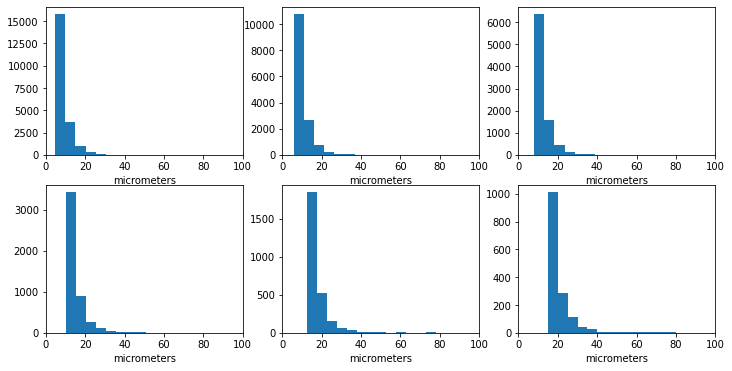

In [6]:
size_threshs = np.linspace(3, 15, 6, endpoint = True)/(b*pixel_res)
fig, ax = plt.subplots(2, 3, figsize = (12,6))
for iplot, size_thresh in enumerate(size_threshs):
    st_chkpt = cp.cuda.Event(); end_chkpt = cp.cuda.Event(); st_chkpt.record()    
    voids_b = Voids()
    voids_b.guess_voids(projs, theta, center, b, b_K)    
    voids_b.select_by_size(size_thresh)
    p_sel, r_fac = voids_b.export_grid(wd)
    p_sel = p_sel.rescale(b)
    print(f'\tSTAT: size thres: {size_thresh:.2f} pixel length')
    end_chkpt.record(); end_chkpt.synchronize(); t_chkpt = cp.cuda.get_elapsed_time(st_chkpt,end_chkpt)
    print(f"time checkpoint {t_chkpt/1000.0:.2f} secs")
    cp.fft.config.clear_plan_cache()
    
    ax.flat[iplot].hist(np.cbrt(voids_b["sizes"])*pixel_res*b, bins = 50)
    ax.flat[iplot].set_xlabel("micrometers")        
    ax.flat[iplot].set_xlim([0,100])

In [9]:
p_sel.vol_shape

(896, 2176, 2176)